http://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [2]:
import glob
import unicodedata
import string
import codecs
import random
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [24]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Load files
==

In [3]:
def findFiles(path): return glob.glob(path)

In [4]:
files = findFiles('data/names/*.txt')

In [5]:
it_ex = codecs.open('data/names/Italian.txt', 'r', 'utf-8').readlines()

In [6]:
it_ex[:5]

[u'Abandonato\n',
 u'Abatangelo\n',
 u'Abatantuono\n',
 u'Abate\n',
 u'Abategiovanni\n']

In [7]:
len(it_ex)

709

Convert to ascii
===

In [8]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [9]:
n_letters

57

In [10]:
def unicodeToAscii(s):
    return str(''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    ))

In [11]:
print(unicodeToAscii(u'Ślusàrski'))

Slusarski


In [12]:
category_lines = {}
all_categories = []

In [13]:
def readLines(filename):
    lines = codecs.open(filename, 'r', 'utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [14]:
for filename in files:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

In [15]:
n_categories = len(all_categories)

In [16]:
all_categories[:5], n_categories

(['Italian', 'Vietnamese', 'Portuguese', 'Japanese', 'Korean'], 18)

In [17]:
category_lines['Vietnamese'][:5]

['Nguyen', 'Tron', 'Le', 'Pham', 'Huynh']

One-hot letter encoding
==

In [18]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

In [19]:
letterToIndex('g')

6

In [20]:
# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

In [21]:
letterToTensor('g')



Columns 0 to 12 
    0     0     0     0     0     0     1     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 56 
    0     0     0     0     0
[torch.FloatTensor of size 1x57]

In [22]:
# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [23]:
print(lineToTensor('Jones').size()) # 1 is batchsize

torch.Size([5, 1, 57])


Define our own RNN
==

In [73]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) # input, hidden -> hidden
        self.i2o = nn.Linear(input_size + hidden_size, output_size) # input, hidden -> output
        self.softmax = nn.LogSoftmax() # softmax on output

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1) # axis == 1
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [85]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

In [87]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(lineToTensor(line))
    return category, line, category_tensor, line_tensor

In [74]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [80]:
input = Variable(lineToTensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)

In [81]:
print(output)

Variable containing:

Columns 0 to 9 
-2.8771 -2.8325 -2.8708 -2.8314 -2.8691 -2.9160 -2.9356 -2.7828 -2.8353 -2.9857

Columns 10 to 17 
-2.9720 -2.8564 -2.8844 -2.9562 -2.8461 -2.9656 -2.9445 -2.8939
[torch.FloatTensor of size 1x18]



In [82]:
print(output.size())

torch.Size([1, 18])


In [84]:
print(categoryFromOutput(output))

('German', 7)


In [88]:
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingPair()
    print('category =', category, '/ line =', line)

('category =', 'Irish', '/ line =', 'Ciardha')
('category =', 'English', '/ line =', 'Froy')
('category =', 'Chinese', '/ line =', 'Guang')
('category =', 'Spanish', '/ line =', 'Ubina')
('category =', 'Spanish', '/ line =', 'Martinez')
('category =', 'Dutch', '/ line =', 'Amstel')
('category =', 'English', '/ line =', 'Fish')
('category =', 'Italian', '/ line =', 'Gentile')
('category =', 'French', '/ line =', 'Lyon')
('category =', 'English', '/ line =', 'Browne')


Train
==

In [92]:
def train_step(category_tensor, line_tensor):
    criterion = nn.NLLLoss()
    learning_rate = 0.005
    
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters(): # handy!
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0]

In [96]:
n_epochs = 100000
print_every = 1000
plot_every = 1000

rnn = RNN(n_letters, n_hidden, n_categories)

current_loss = 0
all_losses = []

start = time.time()

for epoch in range(1, n_epochs + 1):
    category, line, category_tensor, line_tensor = randomTrainingPair()
    output, loss = train_step(category_tensor, line_tensor)
    current_loss += loss

    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


1000 0% (0m 2s) 2.8297 Kotoku / Polish ✗ (Japanese)
2000 0% (0m 5s) 2.5386 Avzalov / Russian ✓
3000 0% (0m 7s) 2.5540 Richter / German ✓
4000 0% (0m 10s) 2.5814 Piccirillo / Portuguese ✗ (Italian)
5000 0% (0m 12s) 2.7231 Handal / Russian ✗ (Arabic)
6000 0% (0m 14s) 1.9505 Dunajski / Polish ✓
7000 0% (0m 17s) 2.6274 Waterman / Irish ✗ (English)
8000 0% (0m 19s) 1.8438 Maclean / Scottish ✓
9000 0% (0m 21s) 2.6806 D'cruze / Czech ✗ (Portuguese)
10000 0% (0m 24s) 1.1576 Pham / Vietnamese ✓
11000 0% (0m 26s) 1.7965 Kang / Chinese ✗ (Korean)
12000 0% (0m 28s) 2.2352 Delgado / Portuguese ✗ (Spanish)
13000 0% (0m 30s) 3.0023 Peij / Korean ✗ (Dutch)
14000 0% (0m 33s) 2.5573 Augustin / Scottish ✗ (French)
15000 0% (0m 35s) 4.0884 Shigemitsu / Italian ✗ (Japanese)
16000 0% (0m 37s) 1.8981 Wasem / Arabic ✓
17000 0% (0m 39s) 2.2148 Handzlik / Polish ✗ (Czech)
18000 0% (0m 41s) 0.5689 Abdrakhmanov / Russian ✓
19000 0% (0m 44s) 1.4709 Tsutomu / Japanese ✓
20000 0% (0m 46s) 0.9253 Chu / Vietnamese ✓
2

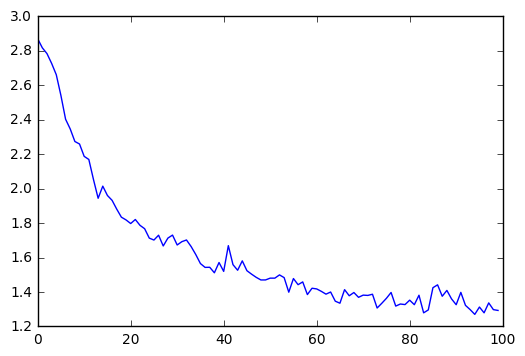

In [100]:
plt.figure()
plt.plot(all_losses)

Confusion matrix
==

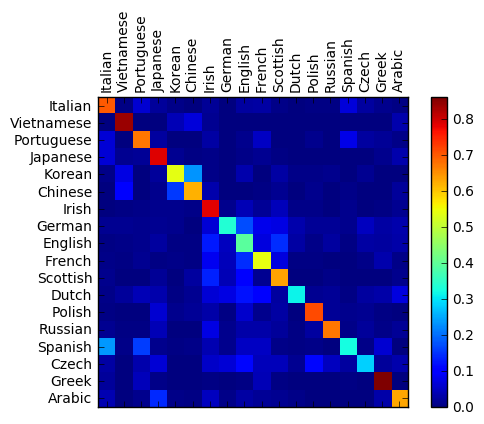

In [101]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingPair()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Running on user input
==

In [103]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(lineToTensor(input_line)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

In [105]:
predict('Lyzhov')
predict('Matsumoto')
predict('Karpathy')
predict('Xiangwen')
predict('Zbigniew')


> Lyzhov
(-0.02) Russian
(-5.02) Polish
(-5.44) English

> Matsumoto
(-0.68) Japanese
(-0.97) Italian
(-3.37) Spanish

> Karpathy
(-0.86) English
(-1.68) Russian
(-2.26) Czech

> Xiangwen
(-0.99) Irish
(-1.21) English
(-2.07) Russian

> Zbigniew
(-1.31) English
(-1.38) French
(-1.96) Russian


Now generate names
==

http://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

In [25]:
class GenRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GenRNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax()

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [26]:
# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

# Make category, input, and target tensors from a random category, line pair
def randomTrainingSet():
    category, line = randomTrainingPair()
    category_tensor = Variable(categoryTensor(category))
    input_line_tensor = Variable(inputTensor(line))
    target_line_tensor = Variable(targetTensor(line))
    return category_tensor, input_line_tensor, target_line_tensor

Training
==

In [27]:
def gen_train_step(category_tensor, input_line_tensor, target_line_tensor):
    criterion = nn.NLLLoss()

    learning_rate = 0.0005

    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])

    loss.backward() # backward on the summed up loss!

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0] / input_line_tensor.size()[0]

In [29]:
rnn = GenRNN(n_letters, 128, n_letters) # hidden_state_size == 128

n_epochs = 100000
print_every = 1000
plot_every = 1000
all_losses = []
total_loss = 0 # Reset every plot_every epochs

start = time.time()

for epoch in range(1, n_epochs + 1):
    output, loss = gen_train_step(*randomTrainingSet())
    total_loss += loss

    if epoch % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), epoch, epoch / n_epochs * 100, loss))

    if epoch % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

1m 0s (1000 0%) 3.2038
1m 52s (2000 0%) 2.7367
2m 19s (3000 0%) 2.6760
2m 27s (4000 0%) 2.9729
2m 38s (5000 0%) 2.7696
2m 47s (6000 0%) 2.5047
2m 58s (7000 0%) 2.6386
3m 11s (8000 0%) 2.7022
3m 29s (9000 0%) 2.9435
3m 45s (10000 0%) 2.2623
4m 0s (11000 0%) 3.6311
4m 13s (12000 0%) 2.6170
4m 27s (13000 0%) 3.5452
4m 40s (14000 0%) 2.7103
4m 52s (15000 0%) 2.4344
5m 3s (16000 0%) 2.5617
5m 14s (17000 0%) 2.9532
5m 25s (18000 0%) 2.4964
5m 35s (19000 0%) 3.1631
5m 43s (20000 0%) 2.4919
5m 53s (21000 0%) 3.5670
6m 4s (22000 0%) 2.2791
6m 13s (23000 0%) 2.2071
6m 22s (24000 0%) 2.1387
6m 31s (25000 0%) 2.3213
6m 42s (26000 0%) 2.4398
6m 52s (27000 0%) 2.7139
7m 6s (28000 0%) 2.6173
7m 18s (29000 0%) 2.1321
7m 28s (30000 0%) 2.2956
7m 38s (31000 0%) 3.0828
7m 47s (32000 0%) 2.8876
7m 56s (33000 0%) 2.0511
8m 5s (34000 0%) 1.9470
8m 13s (35000 0%) 1.6381
8m 22s (36000 0%) 2.0790
8m 32s (37000 0%) 2.5706
8m 43s (38000 0%) 2.4973
8m 51s (39000 0%) 2.5001
9m 1s (40000 0%) 3.0091
9m 11s (41000 0%

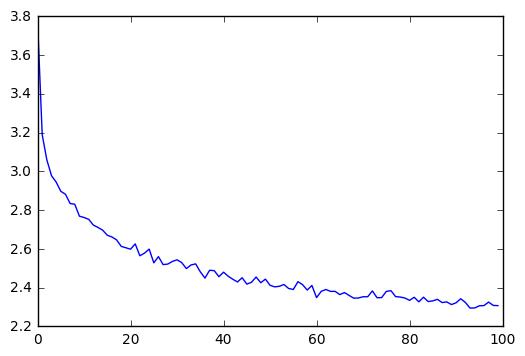

In [31]:
plt.figure()
plt.plot(all_losses)

In [35]:
torch.save(rnn.state_dict(), 'genrnn')

Sampling
==

In [36]:
max_length = 20

In [37]:
# Sample from a category and starting letter
def sample(category, start_letter='A'):
    category_tensor = Variable(categoryTensor(category))
    input = Variable(inputTensor(start_letter))
    hidden = rnn.initHidden()

    output_name = start_letter

    for i in range(max_length):
        output, hidden = rnn(category_tensor, input[0], hidden)
        topv, topi = output.data.topk(1)
        topi = topi[0][0]
        if topi == n_letters - 1:
            break
        else:
            letter = all_letters[topi]
            output_name += letter
        input = Variable(inputTensor(letter))

    return output_name

In [38]:
# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [43]:
samples('Russian', 'LZA')

Lanevan
Zanevev
Allanev


In [44]:
samples('Chinese', 'LZA')

La
Zha
Aun


In [45]:
samples('Polish', 'LZA')

Losen
Zonek
Allon


In [47]:
samples('Irish', 'PSTISTVKU')

Pangan
Sangan
Tongal
Iingan
Sangan
Tanan
Vangan
Kangen
Uonan


Exercises
==

Classification

    Try with a different dataset of line -> category, for example:
        Any word -> language
        First name -> gender
        Character name -> writer
        Page title -> blog or subreddit
    Get better results with a bigger and/or better shaped network
        Add more linear layers
        Try the nn.LSTM and nn.GRU layers
        Combine multiple of these RNNs as a higher level network

Generative

    Try with a different dataset of category -> line, for example:
        Fictional series -> Character name
        Part of speech -> Word
        Country -> City
    Use a “start of sentence” token so that sampling can be done without choosing a start letter
    Get better results with a bigger and/or better shaped network
        Try the nn.LSTM and nn.GRU layers
        Combine multiple of these RNNs as a higher level network